In [1]:
# using the method according to jinjin's paper
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/mchen48/Box/01 Research/PFASs/PFASs_in_Carpet/00 PFAS_US_carpet/PFAS_flows_stocks_data_processing/Basic_data.csv')

In [3]:
# rao input parameters such as the concentration of different PFAS at different scenarios
# the unit of all V parameters are million m2
P_import = 79     # change according to different type of PFAS, ug/m2
P_production  = 10500  # change according to different type of PFAS, ug/m2
P_export = P_production   # change according to different type of PFAS, ug/m2
R_to_carpet = 0.36   # the ratio of collected carpet recycled to carpet
P_yearlyloss_air = 729.813  # change according to different type of PFAS, ug/m2/year. As the specific situation, see the note of PFAS calculation
P_yearlyloss_dust = 0.03942     # change according to different type of PFAS, ug/m2/year
Prod_emi_R = 0.15 # High percentage loss of PFAS during production, related to F9, the high is 0.15, the low is 0.05
xt = 20.6 # ug/L, the average PFAS concentration in landfill leachate from discarded carpets (Table 1 in Jinjin's paper)
SA = 140 # 140 +- 98 tonnes/ha, average mass of waste per surface area for U.S. landfills
LG = 3.26 # m3/ha/day based on the annual precipitation, calculate national leachate generation rate 
R_pro_waste = 0.018 # the material waste during carpet production

In [4]:
# creat a lognormal distribution
age_iniStock = 4.3  # the initial age of nylon carpet stock (in 1990) is 4.3 years old
shape = 0.2957397   # standard deviation
scale = np.exp(2.1080312) # mean
loc = 0
dist = lognorm(shape, loc, scale)

In [5]:
# calculate In-Use Stock of PFAS in nylon carpet
Af = 159 # the average single family house size before 1990 is 159 m2
P_cf = 0.51
S0_volumn = (Af/3.35) * P_cf * df.loc[0,'us_pop'] * df.loc[0,'Percent_nylon'] # Calculate the initial carpet stock volumn in use (initial average family size 3.35)
S0_PFAS  = (S0_volumn * P_production * 0.85)/1000  # Calculate the initial PFAS stock in use

In [6]:
# creat the column of F1_NP_High
df['F1'] = 0 ## the unit of F1_SP_High is kg

In [7]:
# calculate F1: PFAS flow in imported nylon carpet
for i in range(len(df)):
    df.loc[i,'F1'] = (df.loc[i,'V_import'] * P_import * df.loc[i,'Percent_nylon'] - 
                              df.loc[i,'V_export'] * P_export * df.loc[i,'Percent_nylon'])/1000

In [8]:
# creat the column of F_production
df['F_production'] = 0 ## the unit of F_production is kg

In [9]:
# calculate F_production:PFAS flow used in the domestic carpet production in nylon carpet
for i in range(len(df)):
    df.loc[i,'F_production'] = (df.loc[i,'V_production'] * P_production * df.loc[i,'Percent_nylon'])/1000

In [10]:
df['F3'] = 0 

In [11]:
# calculate F3:PFAS flow in material loss in production
for i in range(len(df)):
    df.loc[i,'F3'] = df.loc[i,'F_production'] * 0.12 * 0.15

In [12]:
df_yearly_EoL = pd.DataFrame() #creat an empty dataframe to store every year's EoL carpet according to lognormal distribution

In [13]:
for year in range(1990,2061):
    df_yearly_EoL[year] = 0

In [14]:
for i in range(0,71):
    df_yearly_EoL.loc[i,:] = 0

In [15]:
for i in range(0,71):
    for year in range(1990,2061):
        if year >= df.loc[i,'year']:
            df_yearly_EoL.loc[i,year] = (dist.cdf(year - df.loc[i,'year'] + 1) - dist.cdf(year - df.loc[i,'year'])) * df.loc[i,'V_sales_nylon']
        else:
            df_yearly_EoL.loc[i,year] = df_yearly_EoL.loc[i,year]

In [18]:
# creat a column to store the EoL of initial stock, lognormal distribution, initial age is 4.3 years
# mean and std are the same as yearly EoL of sales volumn
df['V_iniStock_EoL'] = 0

In [19]:
for i in range(0,71):
    df.loc[i,'V_iniStock_EoL'] = ((dist.cdf(age_iniStock+i+1) - dist.cdf(age_iniStock+i))/
                                  (1-dist.cdf(age_iniStock)))*S0_volumn       

In [20]:
df

,year,us_pop,V_sales,V_sales_nylon,V_import,V_export,V_production,Percent_nylon,RR_total,RR_total_24,IncR,PhaseOut,F1,F_production,F3,V_iniStock_EoL
0,1990,249.350726,855.272990,522.464888,171.054598,85.527299,783.855083,0.611,0.040,0.04,0.02,1.0,-540.443752,5028.822282,90.518801,2.027622e+02
1,1991,252.321287,865.462014,528.689108,173.092403,86.546201,793.193292,0.611,0.040,0.04,0.02,1.0,-546.882158,5088.731566,91.597168,4.287282e+02
2,1992,255.322416,875.755887,534.977377,175.151177,87.575589,802.627595,0.611,0.040,0.04,0.02,1.0,-553.386817,5149.257335,92.686632,5.961660e+02
3,1993,258.148860,885.450590,540.899629,177.090118,88.545059,811.512761,0.611,0.040,0.04,0.02,1.0,-559.512863,5206.260115,93.712682,6.314899e+02
4,1994,260.741495,894.343328,546.331980,178.868666,89.434333,819.662928,0.611,0.040,0.04,0.02,1.0,-565.132150,5258.547513,94.653855,5.569805e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2056,394.338337,1186.958394,546.000861,391.696270,94.956672,906.536452,0.460,0.051,0.24,0.02,0.0,-444.406481,4378.571063,78.814279,2.288132e-10
67,2057,395.892993,1191.637909,548.153438,393.240510,95.331033,910.110419,0.460,0.051,0.24,0.02,0.0,-446.158528,4395.833325,79.125000,1.594633e-10
68,2058,397.461590,1196.359386,550.325317,394.798597,95.708751,913.716435,0.460,0.051,0.24,0.02,0.0,-447.926286,4413.250382,79.438507,1.117073e-10
69,2059,399.045644,1201.127388,552.518599,396.372038,96.090191,917.357985,0.460,0.051,0.24,0.02,0.0,-449.711463,4430.839068,79.755103,7.807055e-11


In [21]:
# generate a column to store the yearly EoL from every year's new sales to the market
df['V_new_EoL'] = 0

In [22]:
# calculate the yearly end of life carpet volumn
b = 0
for year in range(1990, 2061):
    a = 0
    for i in range(0,71):
        a = a + df_yearly_EoL.loc[i,year]
    df.loc[b,'V_new_EoL'] = a
    b = b + 1

In [24]:
# generate a column to store the total EoL volumn from stock carpet and every year's new carpet
df['V4'] = 0

In [25]:
for i in range(0,71):
    df.loc[i,'V4'] = df.loc[i,'V_iniStock_EoL'] + df.loc[i,'V_new_EoL']

In [27]:
df['V_delta_S'] = 0 # add a column to stock yearly nylon carpet volumn stock change

In [28]:
# calculate the yearly change of nylon carpet in use stock
for i in range(0,71):
     df.loc[i,'V_delta_S'] = df.loc[i,'V_sales_nylon'] - df.loc[i,'V4']

In [30]:
df['V_stock'] = 0 # add a column to stock yearly total nylon carpet volumn stock 

In [31]:
# calculate the total carpet in stock every year
df.loc[0,'V_stock'] = S0_volumn + df.loc[0,'V_delta_S']
for i in range(1,71):
     df.loc[i,'V_stock'] = df.loc[i-1,'V_stock'] + df.loc[i, 'V_delta_S']

In [33]:
df['F_to_air'] = 0 # add a column to stock yearly in use PFAS lost to air

In [34]:
df['F_to_dust'] = 0 # add a column to stock yearly in use PFAS lost to dust

In [35]:
df['F6'] = 0 # add a column to stock yearly PFAS emission from in use carpet

In [36]:
# calculate the PFAS emissions from in-use stock
for i in range(0,71):
    df.loc[i,'F_to_air'] = P_yearlyloss_air * df.loc[i,'V_stock']/1000
    df.loc[i,'F_to_dust'] = P_yearlyloss_dust * df.loc[i,'V_stock']/1000
    df.loc[i,'F6'] = (df.loc[i,'F_to_air'] + df.loc[i,'F_to_dust'])*2

### In_use stock calculation

In [38]:
df['F_delta_S'] = 0 # add a column to stock yearly total PFAS change in stock

In [39]:
df['F_stock'] = 0 # add a column to stock yearly total PFAS in stock

In [40]:
df['F2'] = 0
df['F4'] = 0
df['F5'] = 0

In [41]:
#method 2: using the method in excel template, according to the potion of in use carpet to calculate
df.loc[0,'F4'] = (df.loc[0,'V4']/S0_volumn)*S0_PFAS
df.loc[0,'F2'] = df.loc[0,'F1'] + df.loc[0,'F_production'] + df.loc[0,'F5']- df.loc[0,'F3']
df.loc[0,'F_delta_S'] = df.loc[0,'F2'] - df.loc[0,'F4'] - df.loc[0,'F6']
df.loc[0,'F_stock'] = df.loc[0,'F_delta_S'] + S0_PFAS
for i in range(1,71):
    if df.loc[i-1, 'F_stock'] > 0:
        df.loc[i,'F4'] = (df.loc[0,'V4']/df.loc[i-1,'V_stock'])*df.loc[i-1,'F_stock']
        df.loc[i,'F5'] = df.loc[i-1,'F4'] * df.loc[i,'RR_total'] * R_to_carpet
        df.loc[i,'F2'] = df.loc[i,'F1'] + df.loc[i,'F_production'] + df.loc[i,'F5']- df.loc[i,'F3']
        df.loc[i,'F_delta_S'] = df.loc[i,'F2'] - df.loc[i,'F4'] - df.loc[i,'F6']
        df.loc[i,'F_stock'] = df.loc[i,'F_delta_S'] + df.loc[i-1,'F_stock']
    elif df.loc[i-1, 'F_stock'] < 0:
        df.loc[i-1,'F_stock'] = df.loc[i-2,'F_stock']
        df.loc[i,'F4'] = (df.loc[0,'V4']/df.loc[i-1,'V_stock'])*df.loc[i-1,'F_stock']
        df.loc[i,'F5'] = df.loc[i-1,'F4'] * df.loc[i,'RR_total'] * R_to_carpet
        df.loc[i,'F2'] = df.loc[i,'F1'] + df.loc[i,'F_production'] + df.loc[i,'F5']- df.loc[i,'F3']
        df.loc[i,'F_delta_S'] = df.loc[i,'F2'] - df.loc[i,'F4'] - df.loc[i,'F6']
        df.loc[i,'F_stock'] = df.loc[i,'F_delta_S'] + df.loc[i-1,'F_stock']

In [43]:
df['F8'] = 0

In [44]:
# calculate the PFAS flow in discarded carpet to incineration
for i in range(0,71):
    df.loc[i,'F8'] = (df.loc[i,'F4'] + df.loc[i,'F3']) * df.loc[i,'IncR']

In [46]:
df['F9'] = 0

In [47]:
# calculate the PFAS emission during carpet production
for i in range(0,71):
    df.loc[i,'F9'] = df.loc[i,'F_production'] * Prod_emi_R

In [49]:
df['F_EoL_total'] = 0

In [50]:
# calculate the yearly total EoL, including F4 and F3
for i in range(0,71):
    df.loc[i,'F_EoL_total'] = df.loc[i,'F3'] + df.loc[i,'F4']

In [52]:
df['landfill_ratio'] = 0 # the ratio is calculated using 1 - recycle ratio - incineration ratio

In [53]:
for i in range(0,71):
    df.loc[i,'landfill_ratio'] = 1 - df.loc[i,'RR_total'] - df.loc[i,'IncR']

In [54]:
df['F_landfill_yearly'] = 0 # store every year's landfill PFAS

In [55]:
# calculate the yearly landfill PFAS
for i in range(0,71):
    df.loc[i,'F_landfill_yearly'] = df.loc[i,'F_EoL_total'] * df.loc[i,'landfill_ratio']

In [57]:
df['F_accu_landfill'] = 0 # store accumulated landfill PFAS, in unit of tonnes

In [58]:
# calculate the accumulated PFAS to landfill for every year
for i in range(0,71):
    a = 0
    for j in range(0,i+1):
        a = a + df.loc[j,'F_landfill_yearly']
    df.loc[i,'F_accu_landfill'] = a

In [60]:
df['V_annual_landfill'] = 0 # million m2, creat a column to store the volumn of end of life carpet, including discarded carpet and waste from production.

In [61]:
# calculate the annual volumn of carpet to landfill, including in use EoL and production waste.
for i in range(0,71):
    df.loc[i,'V_annual_landfill'] = df.loc[i,'V4'] * df.loc[i,'landfill_ratio'] + df.loc[i,'V_production'] * df.loc[i,'Percent_nylon'] * R_pro_waste

In [63]:
df['V_accum_landfill'] = 0 # million m2, creat a column to store the volumn of accumulated carpet in landfills

In [64]:
# calculate the accumulated volumn of carpet to landfill for every year
for i in range(0,71):
    a = 0
    for j in range(0,i+1):
        a = a + df.loc[j,'V_annual_landfill']
    df.loc[i,'V_accum_landfill'] = a

In [66]:
df['Mass_accum_landfill'] = 0 # tonnes, the mass of carpet accumulated in landfill

In [67]:
for i in range(0,71):
    df.loc[i,'Mass_accum_landfill'] = df.loc[i,'V_accum_landfill'] * 23.9 * 1000  ## the unit is metric tons

In [68]:
df['PFAS_landfill_leachate'] = 0 # Kg/year, the mass of PFAS leachated from landfilled carpet

In [69]:
for i in range(0,71):
    df.loc[i,'PFAS_landfill_leachate'] = df.loc[i,'Mass_accum_landfill'] * xt * LG/140 * 365/1000000 * 0.35

In [70]:
df

,year,us_pop,V_sales,V_sales_nylon,V_import,V_export,V_production,Percent_nylon,RR_total,RR_total_24,...,F8,F9,F_EoL_total,landfill_ratio,F_landfill_yearly,F_accu_landfill,V_annual_landfill,V_accum_landfill,Mass_accum_landfill,PFAS_landfill_leachate
0,1990,249.350726,855.272990,522.464888,171.054598,85.527299,783.855083,0.611,0.040,0.04,...,38.003435,754.323342,1900.171732,0.940,1786.161428,1786.161428,199.217337,199.217337,4.761294e+06,291.771404
1,1991,252.321287,865.462014,528.689108,173.092403,86.546201,793.193292,0.611,0.040,0.04,...,31.837248,763.309735,1591.862382,0.940,1496.350640,3282.512068,411.728480,610.945818,1.460161e+07,894.784167
2,1992,255.322416,875.755887,534.977377,175.151177,87.575589,802.627595,0.611,0.040,0.04,...,28.147538,772.388600,1407.376906,0.940,1322.934292,4605.446360,569.380992,1180.326809,2.820981e+07,1728.692971
3,1993,258.148860,885.450590,540.899629,177.090118,88.545059,811.512761,0.611,0.040,0.04,...,25.864620,780.939017,1293.231002,0.940,1215.637142,5821.083502,606.129519,1786.456328,4.269631e+07,2616.423242
4,1994,260.741495,894.343328,546.331980,178.868666,89.434333,819.662928,0.611,0.040,0.04,...,23.997996,788.782127,1199.899776,0.940,1127.905790,6948.989292,555.166193,2341.622521,5.596478e+07,3429.513217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2056,394.338337,1186.958394,546.000861,391.696270,94.956672,906.536452,0.460,0.051,0.24,...,1.744399,656.785659,87.219934,0.929,81.027319,16698.926046,498.987936,32512.236886,7.770425e+08,47617.045489
67,2057,395.892993,1191.637909,548.153438,393.240510,95.331033,910.110419,0.460,0.051,0.24,...,1.749959,659.374999,87.497926,0.929,81.285573,16780.211619,500.946189,33013.183075,7.890151e+08,48350.725474
68,2058,397.461590,1196.359386,550.325317,394.798597,95.708751,913.716435,0.460,0.051,0.24,...,1.755576,661.987557,87.778811,0.929,81.546516,16861.758134,502.905666,33516.088741,8.010345e+08,49087.275286
69,2059,399.045644,1201.127388,552.518599,396.372038,96.090191,917.357985,0.460,0.051,0.24,...,1.761257,664.625860,88.062860,0.929,81.810397,16943.568531,504.869639,34020.958379,8.131009e+08,49826.701509


In [54]:
df.to_csv('NP_HIGH_METHOD1.csv', index = False)

<Axes: >

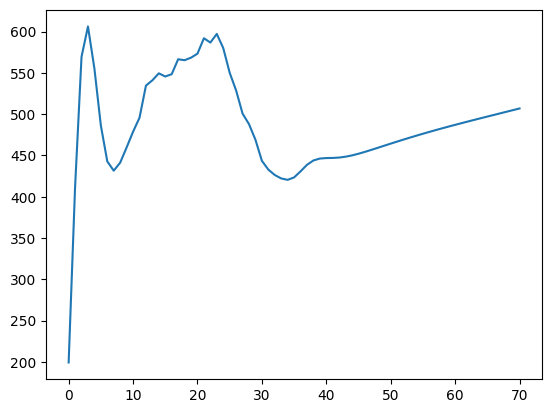

In [55]:
df["V_annual_landfill"].plot()